# Q2
__ See Assignment2_practical.pdf __ 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
import torch.nn.init
from torch.nn.init import calculate_gain
from torchvision import datasets, models, transforms

import random
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


import time
import os
from PIL import Image 
from PIL import ImageFilter


from sklearn.utils.extmath import cartesian

from utilities import linear_ini
from utilities import adjust_lr
from utilities import N_prediction
from utilities import N_prediction_2
from utilities import L2_weights_norm
from utilities import set_parameters

cuda = False

########################################################################################################################
########################################################################################################################
########################################################################################################################

def text_plot(ax_, string, alpha, color, fontsize):
	delta = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
	xt = alpha[0] * delta[0] + ax_.get_xlim()[0]
	yt = alpha[1] * delta[1] + ax_.get_ylim()[0]    
	ax_.text(xt, yt, string, fontsize=fontsize,color=color)

def batch_accuracy(data_batch,model): 
	correct = 0
	total = 0
	for batch_idx, (inputs, targets) in enumerate(data_batch):
		targets = targets.squeeze()
		if cuda:
			inputs, targets = inputs.cuda(), targets.cuda()
		inputs, targets = Variable(inputs), Variable(targets)
		outputs = model(inputs)
		total += targets.size(0)

		_, pred = torch.max(outputs.data, 1)
		pred = Variable(pred)
		correct += float((pred == targets).sum())

	return 100*correct/total, total - correct

def batch_prediction(data_batch,model,criterion): 
	loss = 0
	correct = 0
	total = 0
	for batch_idx, (inputs, targets) in enumerate(data_batch):
		targets = targets.squeeze()
		if cuda:
			inputs, targets = inputs.cuda(), targets.cuda()
		inputs, targets = Variable(inputs), Variable(targets)
		outputs = model(inputs)
		loss += criterion(outputs, targets).data[0]
		total += targets.size(0)

		_, pred = torch.max(outputs.data, 1)
		pred = Variable(pred)
		correct += float((pred == targets).sum())

	return loss/total, 100*correct/total, total - correct

def parameters(i,p,k,s):
	return (i + 2*p - k)/s + 1

def standardized(x, mean, std):
	'''
	mean and std dimension : 1 x 3 x 1 x 1 
	see function mean_std
	'''
	return torch.div((x - mean), std)

def mean_std(x):
	'''
	Returns the mean and std of all pixels, 1 x 3 x 1 x 1
	'''
	n = x.shape[0]
	x = x.permute(1,0,2,3).contiguous()
	mean = torch.mean(x.view(3,n*64*64),1)[None,:,None,None]
	std = torch.std(x.view(3,n*64*64),1)[None,:,None,None]
	return mean, std

def weights_init_1d(m):
	classname = m.__class__.__name__

	if isinstance(m, nn.BatchNorm1d):
		m.weight.data.normal_(0, 1)
		m.bias.data.fill_(0)		

	elif isinstance(m, nn.Linear):
		nn.init.xavier_uniform(m.weight.data, gain=calculate_gain('relu'))
		nn.init.constant(m.bias.data, 0)

def weights_init_2d(m):
	classname = m.__class__.__name__

	if isinstance(m, nn.Conv2d):
		nn.init.kaiming_uniform(m.weight.data, mode='fan_in')
		nn.init.constant(m.bias.data, 0)
	elif isinstance(m, nn.BatchNorm2d):
		m.weight.data.normal_(0, 1)
		m.bias.data.fill_(0)

def save_model(m, optim, e_, ckpt_fname):
		state_dict = m.state_dict()
		for key in state_dict.keys():
			state_dict[key] = state_dict[key].cpu()
        
		torch.save({
			'epoch': e_,
			'state_dict': state_dict},
			ckpt_fname)
			# 'optimizer': optim

class MultipleOptimizer(object):
	def __init__(self, *op):
		self.optimizers = op

	def zero_grad(self):
		for op in self.optimizers:
			op.zero_grad()

	def step(self):
		for op in self.optimizers:
			op.step()

def opt_func(opt):
	if opt == 'adam':
		optimizer = MultipleOptimizer(
			optim.Adam(model.features.parameters(), lr=0.001), 
			optim.Adam(model.classifier.parameters(), lr=0.01))
	elif opt == 'sgd':
		optimizer = MultipleOptimizer(
			optim.SGD(model.features.parameters(), lr=0.01, momentum=0.9), 
			optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9))
	return optimizer

def train_model(nb_epochs, directory, filename):
	
	acc_optimal = 0
	loss_train = np.empty([nb_epochs])
	loss_valid = np.empty([nb_epochs])
	error_train = np.empty((nb_epochs)) 
	error_valid = np.empty((nb_epochs)) 
	acc_train = np.empty((nb_epochs)) 
	acc_valid = np.empty((nb_epochs)) 
	
	for epoch in range(nb_epochs):
		model.train()
		for batch_idx, (inputs, targets) in enumerate(train_batch):
			targets = targets.squeeze()
			if cuda:
				inputs, targets = inputs.cuda(), targets.cuda()
	
			optimizer.zero_grad()
			inputs, targets = Variable(inputs), Variable(targets)
			outputs = model(inputs)
	
			loss = criterion(outputs, targets)
			loss.backward()
			optimizer.step()
	
		model.eval()
		loss_train[epoch], acc_train[epoch], error_train[epoch] = batch_prediction(train_batch, model, criterion)
		loss_valid[epoch], acc_valid[epoch], error_valid[epoch] = batch_prediction(valid_batch, model, criterion) 
		
		if acc_valid[epoch] > acc_optimal:
			acc_optimal = acc_valid[epoch]
			model_optimal = model.state_dict()
			epoch_optimal = epoch

		print('Epoch {}, loss = {},  {}, accuracy = {},  {}'.format(epoch, loss_train[epoch], loss_valid[epoch], acc_train[epoch], acc_valid[epoch]))

	torch.save(model_optimal, directory+'/Model_optimal.pth')
	print('done!')   

	with open(directory+'/'+filename, 'wb') as  f: 
		pickle.dump([loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal], f)




In [2]:

transform = transforms.Compose([transforms.ToTensor()])

dd = torchvision.datasets.ImageFolder('../datasets/test_64x64/',transform)
test_data_0 = torch.Tensor(len(dd),3,64,64) 
test_labels = torch.Tensor(len(dd),1) 

for i, dd_ in enumerate(dd):
	test_data_0[i] = dd_[0]
	test_labels[i] = dd_[1]

test_data_mean, test_data_std = mean_std(test_data_0)
test_data = standardized(test_data_0, test_data_mean, test_data_std)
test_labels = test_labels.long()

dd = torchvision.datasets.ImageFolder('../datasets/valid_64x64/',transform)

valid_data = torch.Tensor(len(dd),3,64,64) 
valid_labels = torch.Tensor(len(dd),1) 

for i, dd_ in enumerate(dd):
    valid_data[i] = dd_[0]
    valid_labels[i] = dd_[1]

valid_data_mean, valid_data_std = mean_std(valid_data)
valid_data = standardized(valid_data, valid_data_mean, valid_data_std)
valid_labels = valid_labels.long()

dd = torchvision.datasets.ImageFolder('../datasets/train_64x64/',transform)

train_data = torch.Tensor(len(dd),3,64,64) 
train_labels = torch.Tensor(len(dd),1) 

for i, dd_ in enumerate(dd):
    train_data[i] = dd_[0]
    train_labels[i] = dd_[1]

train_data_mean, train_data_std = mean_std(train_data)
train_data = standardized(train_data, train_data_mean, train_data_std)
train_labels = train_labels.long()


batch_size = 64
train_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(train_data,train_labels), batch_size=batch_size, shuffle=True)
valid_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(valid_data,valid_labels), batch_size=batch_size, shuffle=False)
test_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(test_data,test_labels), batch_size=batch_size, shuffle=False)    
test_batch_0 = torch.utils.data.DataLoader(data_utils.TensorDataset(test_data_0,test_labels), batch_size=batch_size, shuffle=False)    

print('Data loaded!')


Data loaded!


In [3]:
from Q2_model_a import Classifier
m_a = Classifier()
from Q2_model_b import Classifier
m_b = Classifier()
from Q2_model_d import Classifier
m_d = Classifier()
from Q2_model_e import Classifier
m_e = Classifier()

def para(m):
    m_p = filter(lambda p: p.requires_grad, m.parameters())
    p = sum([np.prod(p.size()) for p in m_p])
    return p

p_a = para(m_a)
p_b = para(m_b)
p_d = para(m_d)
p_e = para(m_e)
    
print('Model A number of parameters = '+str(p_a/1e6)+'M')
print('Model B number of parameters = '+str(p_b/1e6)+'M')
print('Model D number of parameters = '+str(p_d/1e6)+'M')
print('Model E number of parameters = '+str(p_e/1e6)+'M')

Model A number of parameters = 10.309186M
Model B number of parameters = 10.494082M
Model D number of parameters = 15.806338M
Model E number of parameters = 20.528002M


In [4]:
print('Model A ')
print('------------------------------')
with open('SaveData/Q2/Model_A_Adam/log_A', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Kaiming  - Error rate = {:.5}%'.format(100 - acc_optimal))

with open('SaveData/Q2/Model_A_Pretrained_Adam/log_A', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Pre-trained  - Error rate = {:.5}%'.format(100 - acc_optimal))
print(' ')





print('Model B ')
print('------------------------------')
with open('SaveData/Q2/Model_B_Adam/log_B', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Kaiming  - Error rate = {:.5}%'.format(100 - acc_optimal))

with open('SaveData/Q2/Model_B_Pretrained_Adam/log_B', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Pre-trained  - Error rate = {:.5}%'.format(100 - acc_optimal))
print(' ')






print('Model D ')
print('------------------------------')
with open('SaveData/Q2/Model_D_Adam/log_D', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Kaiming  - Error rate = {:.5}%'.format(100 - acc_optimal))

with open('SaveData/Q2/Model_D_Pretrained_Adam/log_D', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Pre-trained  - Error rate = {:.5}%'.format(100 - acc_optimal))
print(' ')





print('Model E ')
print('------------------------------')
with open('SaveData/Q2/Model_E_Adam/log_E', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Kaiming  - Error rate = {:.5}%'.format(100 - acc_optimal))

with open('SaveData/Q2/Model_E_Pretrained_Adam/log_E', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Pre-trained  - Error rate = {:.5}%'.format(100 - acc_optimal))
print(' ')





Model A 
------------------------------
Kaiming  - Error rate = 7.7539%
Pre-trained  - Error rate = 5.928%
 
Model B 
------------------------------
Kaiming  - Error rate = 6.4282%
Pre-trained  - Error rate = 5.7779%
 
Model D 
------------------------------
Kaiming  - Error rate = 6.5533%
Pre-trained  - Error rate = 5.7529%
 
Model E 
------------------------------
Kaiming  - Error rate = 6.6033%
Pre-trained  - Error rate = 6.3532%
 


In [5]:
print(100 - 91.25825165033007)
print(100 - 93.27865573114623)
print(100 - 92.51850370074015)
print(100 - 92.61852370474095)

print(100 - 93.138627725545)

8.741748349669933
6.72134426885377
7.481496299259845
7.3814762952590485
6.861372274454993


# Q2 (c)

In [6]:
class Classifier(nn.Module):
	def __init__(self):
		super(Classifier, self).__init__()
		self.features = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),			
			nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),			
			nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
			nn.Dropout(p=0.5),

			nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
			nn.Dropout(p=0.5),
		
			nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
			nn.Dropout(p=0.5),

			nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
			nn.Dropout(p=0.5),

			nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
			nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
			nn.Dropout(p=0.5))
        
		self.classifier = nn.Sequential(
			nn.Linear(2048, 512),
			nn.BatchNorm1d(512),
			nn.Dropout(p=0.5),
			nn.ReLU(),
			nn.Linear(512, 64),
			nn.BatchNorm1d(64),
			nn.Dropout(p=0.5),
			nn.ReLU(),
			nn.Linear(64, 2))

	def select_layer(self):
		conv_all = [self.features[0], self.features[3], 
                    self.features[8], self.features[11], 
                    self.features[16], self.features[19], self.features[22], 
                    self.features[27], self.features[30], self.features[33], self.features[36], 
                    self.features[41], self.features[44], self.features[47], self.features[50]]
		return conv_all


	def forward(self, x):
		out = self.features(x)
		out = self.classifier(out.view(out.size(0),-1))
		

		return out

In [7]:
model = Classifier()
model.load_state_dict(torch.load('SaveData/Q2/Model_E_Adam/Model_optimal.pth',
                                 map_location=lambda storage, loc: storage))
cnn_all  = model.select_layer()

In [8]:
images = Variable(list(test_batch_0)[0][0])
targets = Variable(list(test_batch)[0][1])

out =[]
out.append(cnn_all[0](images))

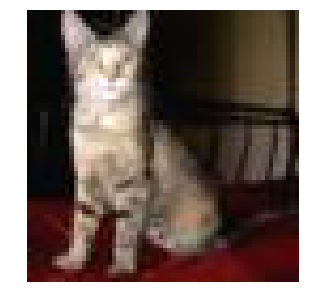

In [9]:
index_animal = 0#17
layer = 0
kernel_ind = [0, 15, 50, 12]
original_image = images[index_animal].data.numpy().transpose(1,2,0)

feature_map_0 = out[layer][index_animal,kernel_ind[0]].data.numpy()
feature_map_1 = out[layer][index_animal,kernel_ind[1]].data.numpy()
feature_map_2 = out[layer][index_animal,kernel_ind[2]].data.numpy()
feature_map_3 = out[layer][index_animal,kernel_ind[3]].data.numpy()

kernel = cnn_all[layer].state_dict()['weight']
kernel_0 = kernel[kernel_ind[0]]
kernel_1 = kernel[kernel_ind[1]]
kernel_2 = kernel[kernel_ind[2]]
kernel_3 = kernel[kernel_ind[3]]

fig, ax0 = plt.subplots(1,figsize=(10,5))
for ax in [ax0]:
    ax.axis('off')
ax0.imshow(original_image, interpolation='nearest')
plt.show()

In [10]:
o = cnn_all[0](images)
print(images.shape)
print(o.shape)
para = cnn_all[0].state_dict()

torch.Size([64, 3, 64, 64])
torch.Size([64, 64, 64, 64])


In [11]:
w = para['weight']
print(w.shape)

torch.Size([64, 3, 3, 3])


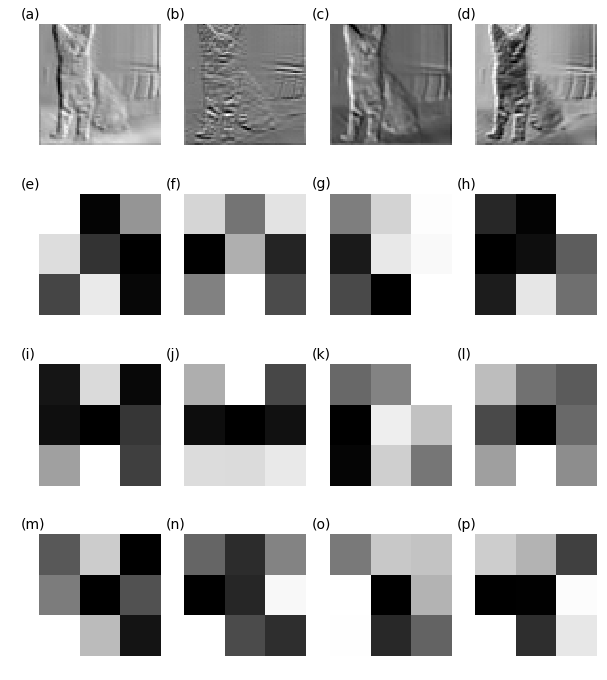

In [12]:
fig, ((ax0,ax1,ax2,ax3), (ax4,ax5,ax6,ax7), (ax8,ax9,ax10,ax11), (ax12,ax13,ax14,ax15)) = plt.subplots(4,4,figsize=(10,12))

ax0.imshow(feature_map_0, interpolation='nearest',cmap='gray')
ax1.imshow(feature_map_1, interpolation='nearest',cmap='gray')
ax2.imshow(feature_map_2, interpolation='nearest',cmap='gray')
ax3.imshow(feature_map_3, interpolation='nearest',cmap='gray')

ax4.imshow(kernel_0[0], interpolation='nearest',cmap='gray')
ax5.imshow(kernel_1[0], interpolation='nearest',cmap='gray')
ax6.imshow(kernel_2[0], interpolation='nearest',cmap='gray')
ax7.imshow(kernel_3[0], interpolation='nearest',cmap='gray')

ax8.imshow(kernel_0[1], interpolation='nearest',cmap='gray')
ax9.imshow(kernel_1[1], interpolation='nearest',cmap='gray')
ax10.imshow(kernel_2[1], interpolation='nearest',cmap='gray')
ax11.imshow(kernel_3[1], interpolation='nearest',cmap='gray')

ax12.imshow(kernel_0[2], interpolation='nearest',cmap='gray')
ax13.imshow(kernel_1[2], interpolation='nearest',cmap='gray')
ax14.imshow(kernel_2[2], interpolation='nearest',cmap='gray')
ax15.imshow(kernel_3[2], interpolation='nearest',cmap='gray')

string = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)']
for i, (ax) in enumerate([ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15]):
    text_plot(ax,string[i], [-0.15,1.05], 'k', 14)
    ax.axis('off')

# plt.tight_layout()

fig.savefig('Figures/Q2/Cats_feature_maps_kernel.pdf')

plt.show()

In [13]:
softmax = nn.Softmax(dim = 1)
x = Variable(list(test_batch)[-4][0])
y = Variable(list(test_batch)[-4][1]).squeeze()
model.eval()
outputs = model(x)
outputs_softmax = softmax(outputs)
_, pred = torch.max(outputs.data, 1)
pred = Variable(pred)
missed_classified = np.argwhere((pred != y).data.numpy() == 1).squeeze()

### Misclassified animals

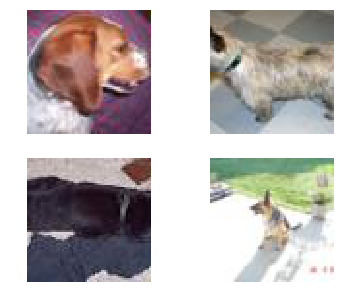

In [14]:
x_0 = Variable(list(test_batch_0)[-4][0])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(6,5))

original_image = x_0[missed_classified[0]].data.numpy().transpose(1,2,0)
ax0.imshow(original_image, interpolation='nearest')

original_image = x_0[missed_classified[1]].data.numpy().transpose(1,2,0)
ax1.imshow(original_image, interpolation='nearest')

original_image = x_0[missed_classified[2]].data.numpy().transpose(1,2,0)
ax2.imshow(original_image, interpolation='nearest')

original_image = x_0[missed_classified[3]].data.numpy().transpose(1,2,0)
ax3.imshow(original_image, interpolation='nearest')

for ax in [ax0,ax1,ax2,ax3]:
    ax.axis('off')

fig.savefig('Figures/Q2/Dogs_missed_classified.pdf')


plt.show()

In [15]:
softmax = nn.Softmax(dim = 1)
x = Variable(list(test_batch)[0][0])
y = Variable(list(test_batch)[0][1]).squeeze()
model.eval()
outputs = model(x)
outputs_softmax = softmax(outputs)
_, pred = torch.max(outputs.data, 1)
pred = Variable(pred)
missed_classified = np.argwhere((pred != y).data.numpy() == 1).squeeze()

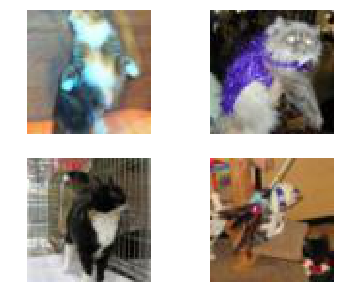

In [16]:
x_0 = Variable(list(test_batch_0)[0][0])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(6,5))

original_image = x_0[missed_classified[0]].data.numpy().transpose(1,2,0)
ax0.imshow(original_image, interpolation='nearest')

original_image = x_0[missed_classified[1]].data.numpy().transpose(1,2,0)
ax1.imshow(original_image, interpolation='nearest')

original_image = x_0[missed_classified[2]].data.numpy().transpose(1,2,0)
ax2.imshow(original_image, interpolation='nearest')

original_image = x_0[missed_classified[3]].data.numpy().transpose(1,2,0)
ax3.imshow(original_image, interpolation='nearest')

for ax in [ax0,ax1,ax2,ax3]:
    ax.axis('off')

fig.savefig('Figures/Q2/Cats_missed_classified.pdf')
plt.show()

### Difficult to classify

In [17]:
from Q2_model_e import Classifier
model = Classifier()
model.load_state_dict(torch.load('SaveData/Q2/Model_E_Adam/Model_optimal.pth',
                                 map_location=lambda storage, loc: storage))



In [18]:
softmax = nn.Softmax(dim = 1)
x = Variable(list(test_batch)[-8][0])
x_0 = Variable(list(test_batch_0)[-8][0])
y = Variable(list(test_batch)[-8][1]).squeeze()
model.eval()
outputs = model(x)
outputs_softmax = softmax(outputs)
_, pred = torch.max(outputs.data, 1)
pred = Variable(pred)
missed_classified = np.argwhere((pred != y).data.numpy() == 1).squeeze()


print('Oops, difficult to classify!')
print(outputs_softmax[7,:])



Oops, difficult to classify!
Variable containing:
 0.5430
 0.4570
[torch.FloatTensor of size 2]



In [19]:
softmax = nn.Softmax(dim = 1)
x = Variable(list(test_batch)[-12][0])
x_0 = Variable(list(test_batch_0)[-12][0])
y = Variable(list(test_batch)[-12][1]).squeeze()
model.eval()
outputs = model(x)
outputs_softmax = softmax(outputs)
_, pred = torch.max(outputs.data, 1)
pred = Variable(pred)
missed_classified = np.argwhere((pred != y).data.numpy() == 1).squeeze()

print('missed_classified')
print('Oops, difficult to classify!')
print(outputs_softmax[59,:]) 

missed_classified
Oops, difficult to classify!
Variable containing:
 0.4809
 0.5191
[torch.FloatTensor of size 2]



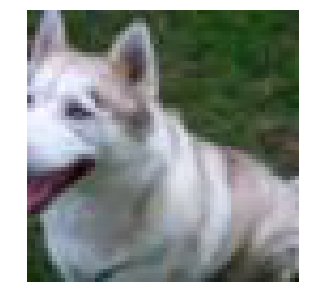

In [20]:
index_animal = 59 # 59
layer = 0
kernel_ind = [0, 15, 50, 12]
original_image = x_0[index_animal].data.numpy().transpose(1,2,0)

fig, ax0 = plt.subplots(1,figsize=(10,5))

ax0.imshow(original_image, interpolation='nearest')
for ax in [ax0]:
    ax.axis('off')

fig.savefig('Figures/Q2/50_50.pdf')
    
plt.show()

## Figures

Model E
Optimal Accuracy = 93.39669834917459%, after 47 epochs


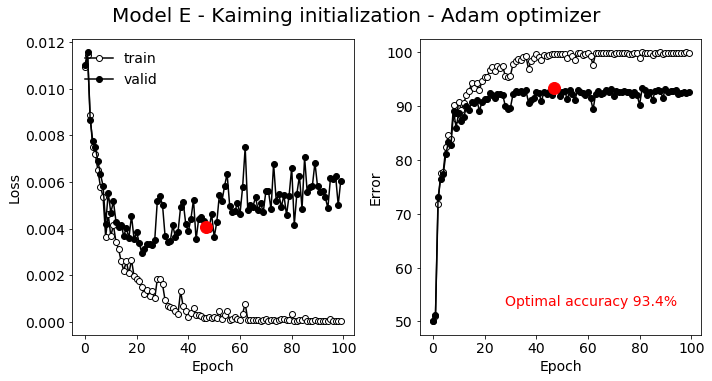

Model E
Optimal Accuracy = 93.64682341170585%, after 18 epochs


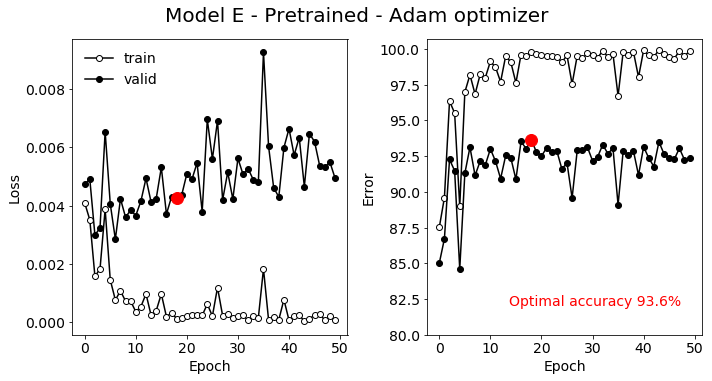

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

with open('SaveData/Q2/Model_E_Adam/log_E', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Model E')
print('Optimal Accuracy = {}%, after {} epochs'.format(acc_optimal, epoch_optimal))


ax1.plot(loss_train,'-ko',markersize=6, markerfacecolor='w')
ax1.plot(loss_valid,'-ko',markersize=6)
ax1.plot([epoch_optimal],loss_valid[epoch_optimal],'or',markersize=12)

ax2.plot(acc_train,'-ko',markersize=6, markerfacecolor='w')
ax2.plot(acc_valid,'-ko',markersize=6)
ax2.plot([epoch_optimal],acc_valid[epoch_optimal],'or',markersize=12)

text_plot(ax2, 'Optimal accuracy {:.3}%'.format(acc_optimal), [0.3,0.1], 'r', 14)

ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Error',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)
ax2.set_xlabel('Epoch',fontsize=14)
for i, ax in enumerate([ax1,ax2]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

legend = ax1.legend(['train','valid'],loc='upper left',fontsize=14,frameon=False)
plt.suptitle('Model E - Kaiming initialization - Adam optimizer', fontsize=20, y=1.05)
plt.tight_layout()

plt.show()        
fig.savefig('Figures/Q2/Model_E_Kaiming_initialization.pdf', bbox_inches='tight')



##########################################################################################
##########################################################################################
##########################################################################################


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

with open('SaveData/Q2/Model_E_Pretrained_Adam/log_E', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Model E')
print('Optimal Accuracy = {}%, after {} epochs'.format(acc_optimal, epoch_optimal))


ax1.plot(loss_train,'-ko',markersize=6, markerfacecolor='w')
ax1.plot(loss_valid,'-ko',markersize=6)
ax1.plot([epoch_optimal],loss_valid[epoch_optimal],'or',markersize=12)

ax2.plot(acc_train,'-ko',markersize=6, markerfacecolor='w')
ax2.plot(acc_valid,'-ko',markersize=6)
ax2.plot([epoch_optimal],acc_valid[epoch_optimal],'or',markersize=12)

ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Error',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)
ax2.set_xlabel('Epoch',fontsize=14)
for i, ax in enumerate([ax1,ax2]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        
ax2.set_ylim([80,None])

text_plot(ax2, 'Optimal accuracy {:.3}%'.format(acc_optimal), [0.3,0.1], 'r', 14)

legend = ax1.legend(['train','valid'],loc='upper left',fontsize=14,frameon=False)
plt.suptitle('Model E - Pretrained - Adam optimizer', fontsize=20, y=1.05)
plt.tight_layout()

plt.show()        
fig.savefig('Figures/Q2/Model_E_Pretrained.pdf', bbox_inches='tight')








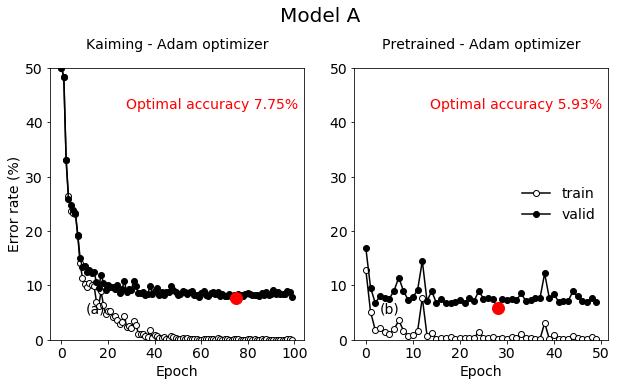

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

with open('SaveData/Q2/Model_A_Adam/log_A', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

ax1.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor='w')
ax1.plot(100 - acc_valid,'-ko',markersize=6)
ax1.plot([epoch_optimal],100 - acc_valid[epoch_optimal],'or',markersize=12)

ax1.set_ylabel('Error rate (%)',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)
ax1.set_ylim([0,50])

text_plot(ax1, 'Optimal accuracy {:.3}%'.format(100 - acc_optimal), [0.3,0.85], 'r', 14)
ax1.set_title('Kaiming - Adam optimizer', fontsize=14, y=1.05)

with open('SaveData/Q2/Model_A_Pretrained_Adam/log_A', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

ax2.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor='w')
ax2.plot(100 - acc_valid,'-ko',markersize=6)
ax2.plot([epoch_optimal],100 - acc_valid[epoch_optimal],'or',markersize=12)

ax2.set_xlabel('Epoch',fontsize=14)
ax2.set_ylim([0, 50])

for i, ax in enumerate([ax1,ax2]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

text_plot(ax2, 'Optimal accuracy {:.3}%'.format(100 - acc_optimal), [0.3,0.85], 'r', 14)
text_plot(ax2, '(b)', [0.1,0.1], 'k', 14)
text_plot(ax1, '(a)', [0.14,0.1], 'k', 14)

legend = ax2.legend(['train','valid'],loc='center right',fontsize=14,frameon=False)
ax2.set_title('Pretrained - Adam optimizer', fontsize=14, y=1.05)
plt.suptitle('Model A', fontsize=20, y=1.05)

plt.show()        
fig.savefig('Figures/Q2/Error_model_A.pdf', bbox_inches='tight')



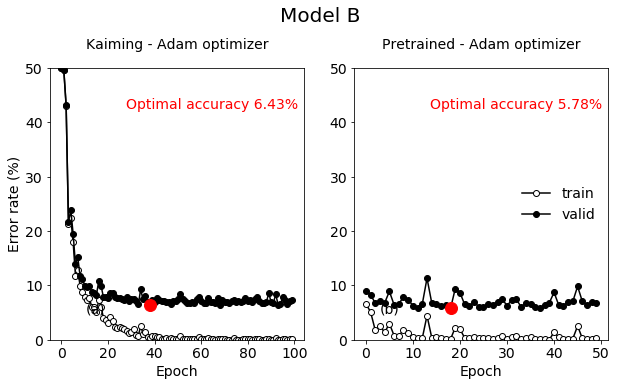

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

with open('SaveData/Q2/Model_B_Adam/log_B', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

ax1.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor='w')
ax1.plot(100 - acc_valid,'-ko',markersize=6)
ax1.plot([epoch_optimal],100 - acc_valid[epoch_optimal],'or',markersize=12)

ax1.set_ylabel('Error rate (%)',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)
ax1.set_ylim([0,50])

text_plot(ax1, 'Optimal accuracy {:.3}%'.format(100 - acc_optimal), [0.3,0.85], 'r', 14)
ax1.set_title('Kaiming - Adam optimizer', fontsize=14, y=1.05)

with open('SaveData/Q2/Model_B_Pretrained_Adam/log_B', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

ax2.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor='w')
ax2.plot(100 - acc_valid,'-ko',markersize=6)
ax2.plot([epoch_optimal],100 - acc_valid[epoch_optimal],'or',markersize=12)

ax2.set_xlabel('Epoch',fontsize=14)
ax2.set_ylim([0, 50])

for i, ax in enumerate([ax1,ax2]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

text_plot(ax2, 'Optimal accuracy {:.3}%'.format(100 - acc_optimal), [0.3,0.85], 'r', 14)
text_plot(ax2, '(b)', [0.1,0.1], 'k', 14)
text_plot(ax1, '(a)', [0.14,0.1], 'k', 14)

legend = ax2.legend(['train','valid'],loc='center right',fontsize=14,frameon=False)
ax2.set_title('Pretrained - Adam optimizer', fontsize=14, y=1.05)
plt.suptitle('Model B', fontsize=20, y=1.05)
plt.show()        
fig.savefig('Figures/Q2/Error_model_B.pdf', bbox_inches='tight')



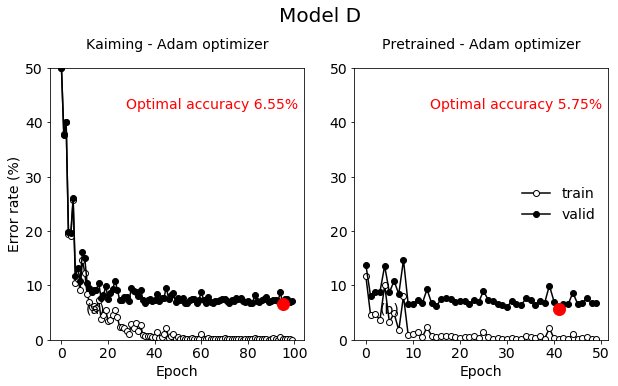

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

with open('SaveData/Q2/Model_D_Adam/log_D', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

ax1.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor='w')
ax1.plot(100 - acc_valid,'-ko',markersize=6)
ax1.plot([epoch_optimal],100 - acc_valid[epoch_optimal],'or',markersize=12)

ax1.set_ylabel('Error rate (%)',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)
ax1.set_ylim([0,50])

text_plot(ax1, 'Optimal accuracy {:.3}%'.format(100 - acc_optimal), [0.3,0.85], 'r', 14)
ax1.set_title('Kaiming - Adam optimizer', fontsize=14, y=1.05)

with open('SaveData/Q2/Model_D_Pretrained_Adam/log_D', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

ax2.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor='w')
ax2.plot(100 - acc_valid,'-ko',markersize=6)
ax2.plot([epoch_optimal],100 - acc_valid[epoch_optimal],'or',markersize=12)

ax2.set_xlabel('Epoch',fontsize=14)
ax2.set_ylim([0, 50])

for i, ax in enumerate([ax1,ax2]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

text_plot(ax2, 'Optimal accuracy {:.3}%'.format(100 - acc_optimal), [0.3,0.85], 'r', 14)
text_plot(ax2, '(b)', [0.1,0.1], 'k', 14)
text_plot(ax1, '(a)', [0.14,0.1], 'k', 14)

legend = ax2.legend(['train','valid'],loc='center right',fontsize=14,frameon=False)
ax2.set_title('Pretrained - Adam optimizer', fontsize=14, y=1.05)
plt.suptitle('Model D', fontsize=20, y=1.05)

plt.show()        
fig.savefig('Figures/Q2/Error_model_D.pdf', bbox_inches='tight')








Model E
Optimal Accuracy = 93.39669834917459%, after 47 epochs


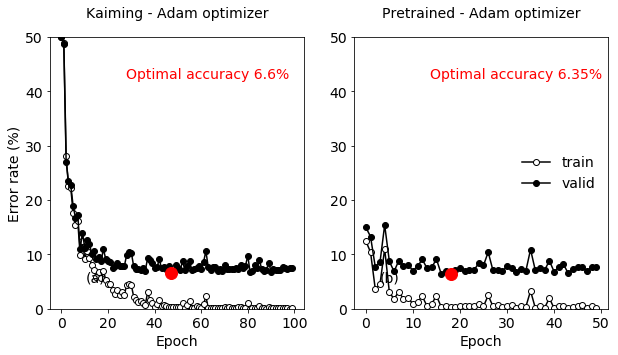

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

with open('SaveData/Q2/Model_E_Adam/log_E', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

print('Model E')
print('Optimal Accuracy = {}%, after {} epochs'.format(acc_optimal, epoch_optimal))

ax1.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor='w')
ax1.plot(100 - acc_valid,'-ko',markersize=6)
ax1.plot([epoch_optimal],100 - acc_valid[epoch_optimal],'or',markersize=12)

ax1.set_ylabel('Error rate (%)',fontsize=14)
ax1.set_xlabel('Epoch',fontsize=14)
ax1.set_ylim([0,50])

text_plot(ax1, 'Optimal accuracy {:.3}%'.format(100 - acc_optimal), [0.3,0.85], 'r', 14)
ax1.set_title('Kaiming - Adam optimizer', fontsize=14, y=1.05)

with open('SaveData/Q2/Model_E_Pretrained_Adam/log_E', 'rb') as f:
    loss_train, acc_train, error_train, loss_valid, acc_valid, error_valid, epoch_optimal, acc_optimal  = pickle.load(f)

ax2.plot(100 - acc_train,'-ko',markersize=6, markerfacecolor='w')
ax2.plot(100 - acc_valid,'-ko',markersize=6)
ax2.plot([epoch_optimal],100 - acc_valid[epoch_optimal],'or',markersize=12)

ax2.set_xlabel('Epoch',fontsize=14)
ax2.set_ylim([0, 50])

for i, ax in enumerate([ax1,ax2]):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

text_plot(ax2, 'Optimal accuracy {:.3}%'.format(100 - acc_optimal), [0.3,0.85], 'r', 14)
text_plot(ax2, '(b)', [0.1,0.1], 'k', 14)
text_plot(ax1, '(a)', [0.14,0.1], 'k', 14)

legend = ax2.legend(['train','valid'],loc='center right',fontsize=14,frameon=False)
ax2.set_title('Pretrained - Adam optimizer', fontsize=14, y=1.05)

plt.show()        
fig.savefig('Figures/Q2/Error_model_E.pdf', bbox_inches='tight')





